<a href="https://colab.research.google.com/github/Felipanjos/a3_ia_2022.2/blob/main/Projeto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/datasets/michaelbryantds/cpu-and-gpu-product-data

### Análise e Entendimento do Problema:

#### Especificação do objetivo geral e dos objetivos específicos

O Objetivo geral do projeto é identificar a relação entre a quantidade dos transistors presentes nos processadores e qual a influência que o tamanho, TDP, entre outras características tem sob o processamento. Dentre os objetivos específicos está o tratamento das informações removendo os outliers, padronizando os dados, analisando as alterações, entre outros.

### a. Especificação do tipo de problema: Quanto à Supervisão, Quanto à Tarefa, Quanto ao Modo;

À FAZER 


b. Especificação das Medidas de Desempenho (para Classificação ou Regressão)


Como metódos de desempenho, os principais utilizados no nosso projeto, se tratam de acurácia para a Classicação e erro quadrático médio para Regressão, esses metódos, são extremamente importantes, pois é através deles que é possível observar o quão precisas estão sendo as predições realizadas pela máquina, por serem duas formas diferentes de Aprendizado de máquina supervisionado, cada um possui seu próprio método de desempenho, para a classificação usaremos o principal citado anteriormente, acurácia, se trata de um indicador da performance geral do modelo, contando quantas classificações foram feitas corretamente, para ser calculado, se torna necessário utilizar a Matriz de confusão, identificando os verdadeiros positivos, falso negativos, falso positivos e verdadeiros negativos, através desses dados é possível montar a Matriz e utilizar a formúla VP+VN/VP+VN+FP+FN para assim medir a acurácia do modelo, já para a regressão utilizaremos o erro quadrático médio, esse método carrega como objetivo encontrar a diferença dos valores iniciais com os valores preditos, quanto mais alta a diferença, maior o problema do modelo, pois os valores encontrados não estão sendo precisos, essa média é calculada através da diferença do valor predito para o valor real, o resultado é elevado ao quadrado, fazendo isso para todos os pontos, como já dito, quanto maior o resultado, mais pobre estão sendo as predições.

##### Hipotese

#################### Fazer Hipotese

Com o avanço tecnológico observa-se um crescimento exponencial na quantidade de transistores em CPU's em função do tempo. De forma inversamente proporcional, é perceptível a redução do tamanho dos componentes. Lei de Moore

# 2.3 Requisitos da Análise de Dados:

#### Dependências

In [28]:
import pandas as pd
import numpy as np
import random
import string
import sklearn
from itertools import groupby
import plotly.express as px
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#import seaborn as sns
import statistics as sts
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Carregando Dataset

In [2]:
df = pd.read_csv('chip_dataset.csv')

### Excluindo colunas sem utilidade

In [3]:
df.drop('FP16 GFLOPS', axis=1, inplace=True)
df.drop('FP32 GFLOPS', axis=1, inplace=True)
df.drop('FP64 GFLOPS', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

### Atribuindo index

In [4]:
df["Release Date"] = pd.to_datetime(df["Release Date"])

In [5]:
df.set_index("Release Date", inplace=True)
df.sort_index(inplace=True)
df.head()

,Product,Type,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
Release Date,,,,,,,,,
2000-01-01,Intel i815 Graphics,GPU,150.0,NaN,NaN,NaN,133.0,Intel,Intel
2000-03-01,NVIDIA Vanta LT,GPU,250.0,NaN,90.0,15.0,105.0,TSMC,NVIDIA
2000-03-04,Sony Playstation 2 GPU 250nm,GPU,250.0,79.0,279.0,54.0,147.0,Sony,Other
2000-04-01,ATI Radeon DDR,GPU,180.0,23.0,115.0,30.0,166.0,TSMC,ATI
2000-04-01,ATI Radeon 7200 64 MB,GPU,180.0,23.0,111.0,30.0,166.0,TSMC,ATI


### Inserindo problemas

##### Selecionando coluna aleatória

In [91]:
# escolhendo uma coluna aleatoriamente
random.seed(8)
n = random.randrange(0,len(df.columns))
coluna_aleatoria = df.columns[n]
coluna_aleatoria

'TDP (W)'

In [8]:
df.head()

,Product,Type,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
Release Date,,,,,,,,,
2000-01-01,Intel i815 Graphics,GPU,150.0,NaN,NaN,NaN,133.0,Intel,Intel
2000-03-01,NVIDIA Vanta LT,GPU,250.0,NaN,90.0,15.0,105.0,TSMC,NVIDIA
2000-03-04,Sony Playstation 2 GPU 250nm,GPU,250.0,79.0,279.0,54.0,147.0,Sony,Other
2000-04-01,ATI Radeon DDR,GPU,180.0,23.0,115.0,30.0,166.0,TSMC,ATI
2000-04-01,ATI Radeon 7200 64 MB,GPU,180.0,23.0,111.0,30.0,166.0,TSMC,ATI


##### a) Selecionando 3% dos dados

In [9]:
p_3 = round(df.shape[0] * 3 / 100)
p_3

146

##### a) Excluindo 3% dos dados aleatoriamente

In [10]:
reg_excluidos = df.sample(n=p_3)
reg_exc_index = reg_excluidos.index.array
df.loc[reg_exc_index, coluna_aleatoria] = np.nan

In [11]:
# listando alterações
df.loc[reg_exc_index]

,Product,Type,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
Release Date,,,,,,,,,
2002-06-24,Intel Pentium 4-M 2.00,CPU,130.0,NaN,131.0,55.0,2000.0,Intel,Intel
2002-06-24,Intel Pentium 4-M 1.90,CPU,130.0,NaN,131.0,55.0,1900.0,Intel,Intel
NaT,Intel Core i7-9850HE,CPU,14.0,NaN,149.0,NaN,2700.0,Intel,Intel
NaT,Intel Core i7-9850HL,CPU,14.0,NaN,149.0,NaN,1900.0,Intel,Intel
NaT,Intel Core i9-10990XE,CPU,14.0,NaN,NaN,NaN,4000.0,Intel,Intel
...,...,...,...,...,...,...,...,...,...
NaT,Intel Xe DG1 OEM,GPU,10.0,NaN,77.0,NaN,900.0,Intel,Intel
NaT,NVIDIA Quadro T400 Mobile,GPU,12.0,NaN,200.0,4700.0,420.0,TSMC,NVIDIA
NaT,AMD Radeon Pro V7300X,GPU,14.0,NaN,232.0,5700.0,1188.0,GF,AMD


##### a) Alterando 3% dos dados aleatoriamente

In [12]:
def gerar_string_aleatoria():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(10)) 

def gerar_numero_aleatorio():
  return random.randint(0, 999)

In [13]:
# listando indexes que sofrerão alteração na coluna aleatória
df_selecao_nao_nulo = df[~df[coluna_aleatoria].isnull()]
reg_alterados = df_selecao_nao_nulo.sample(n=p_3)
reg_alter_index = reg_alterados.index.array

In [14]:
# inserindo alterações na coluna aleatória
colunas_numericas = df.describe().columns

if coluna_aleatoria in colunas_numericas:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_numero_aleatorio()
else:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_string_aleatoria()

In [15]:
# listando alterações
df.loc[reg_alter_index]

,Product,Type,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
Release Date,,,,,,,,,
2006-07-01,Intel GMA 3000,GPU,90.0,379.0,NaN,NaN,400.0,Intel,Intel
2006-07-01,NVIDIA GeForce 7600 GS AGP,GPU,90.0,379.0,125.0,177.0,400.0,TSMC,NVIDIA
2006-07-01,NVIDIA GeForce 7600 GS AGP,GPU,90.0,379.0,196.0,278.0,500.0,TSMC,NVIDIA
2017-01-11,NVIDIA Quadro P5000 Mobile,GPU,16.0,985.0,314.0,7200.0,1278.0,TSMC,NVIDIA
2017-01-11,NVIDIA Quadro M520 Mobile,GPU,28.0,985.0,NaN,NaN,1041.0,TSMC,NVIDIA
...,...,...,...,...,...,...,...,...,...
2017-06-27,AMD Radeon Vega Frontier Edition,GPU,14.0,954.0,495.0,12500.0,1382.0,GF,AMD
2017-06-27,NVIDIA GeForce GTX 1070 Max-Q,GPU,16.0,954.0,314.0,7200.0,1215.0,TSMC,NVIDIA
2007-04-27,Intel Core 2 Duo U7500,CPU,65.0,679.0,111.0,293.0,1073.0,Intel,Intel


### Divisão (Amostragem Estratificada)

In [92]:
df_extr = df.copy()

In [93]:
df_extr.dropna(inplace=True)
df_extr.reset_index(drop=True, inplace=True)

In [94]:
ranges = [0, df_extr['Transistors (million)'].describe()['25%'], 500, 1000, 2000, 6000, 15000, 30000, np.inf]
tiers = ['F', 'E', 'D', 'C', 'B', 'A', 'S', 'S+']

df_extr['Rank'] = pd.cut(df_extr['Transistors (million)'], bins = ranges, labels = tiers)

In [95]:
df_extr['Rank'].value_counts()

F     666
C     518
B     491
D     407
E     331
A     173
S      39
S+      8
Name: Rank, dtype: int64

<AxesSubplot: >

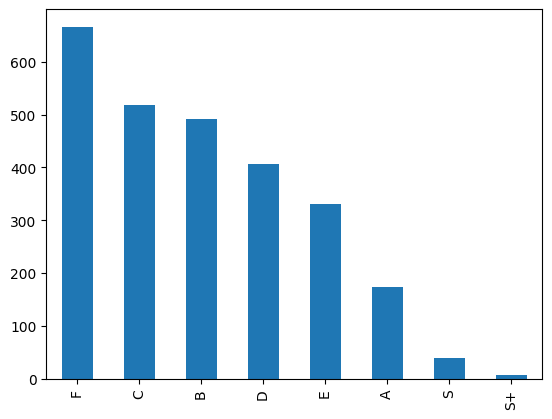

In [96]:
#################### Arrumar a ordem de classificação

df_extr['Rank'].value_counts().plot(kind='bar')

### Tratamento de Dados

##### Excluindo registros duplicados

###### O unico tratamento necessário é a exclusão dos dados duplicados.

In [98]:
df_extr.duplicated().sum()

0

In [97]:
df_extr.drop_duplicates(inplace=True)

In [102]:
df_extr.isnull().sum()

Product                  0
Type                     0
Process Size (nm)        0
TDP (W)                  0
Die Size (mm^2)          0
Transistors (million)    0
Freq (MHz)               0
Foundry                  0
Vendor                   0
Rank                     0
dtype: int64

########################### Fazer Função
##### Tratando dados Ausentes para exploração 

##### Coluna 'Process Size (nm)' 

In [103]:
df_extr["Process Size (nm)"] = df_extr["Process Size (nm)"].fillna(df_extr["Process Size (nm)"].mean())

##### Coluna 'TDP (W)' 

In [104]:
df_extr["TDP (W)"] = df_extr["TDP (W)"].fillna(df_extr["TDP (W)"].mean())

##### Coluna 'Die Size (mm^2)' 

In [105]:
df_extr["Die Size (mm^2)"] = df_extr["Die Size (mm^2)"].fillna(df_extr["Die Size (mm^2)"].mean())

##### Coluna 'Transistors (million)'

In [106]:
df_extr["Transistors (million)"] = df_extr["Transistors (million)"].fillna(df_extr["Process Size (nm)"].mean())

### Exploração 

##### Busca de correlações (Coeficientes de correlação)

In [110]:
colunas_para_calculo = df_extr.describe().columns
print('Coeficiente de correlação de Pearson entre a coluna Transistors (million) e:')

coor_dict = {}
r_list = []

for value in df.corr()['Transistors (million)']:
    if value == 1:
        r = 'relação linear perfeita e positiva'
    elif value == 0:
        r = 'inexistência linear'
    elif value == -1:
        r = 'relação linear perfeita e negativa'
    elif value > 0:
        r = 'relação linear positiva'
    elif value < 0:
        r = 'relação linear negativa'

    r_list.append(r)

print(df_extr.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')

count = 0
for col in colunas_para_calculo: 
    coor_dict[col] = r_list[count]
    print(f'{col}: {coor_dict[col]}')
    count += 1


Coeficiente de correlação de Pearson entre a coluna Transistors (million) e:
Process Size (nm)       -0.385668
TDP (W)                  0.114432
Die Size (mm^2)          0.623823
Transistors (million)    1.000000
Freq (MHz)              -0.035443
Name: Transistors (million), dtype: float64 

Process Size (nm): relação linear negativa
TDP (W): relação linear positiva
Die Size (mm^2): relação linear positiva
Transistors (million): relação linear perfeita e positiva
Freq (MHz): relação linear positiva


C:\Users\amr\AppData\Local\Temp\ipykernel_13856\1789113163.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\amr\AppData\Local\Temp\ipykernel_13856\1789113163.py:21: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



##### Analise de Transistors x Die Size

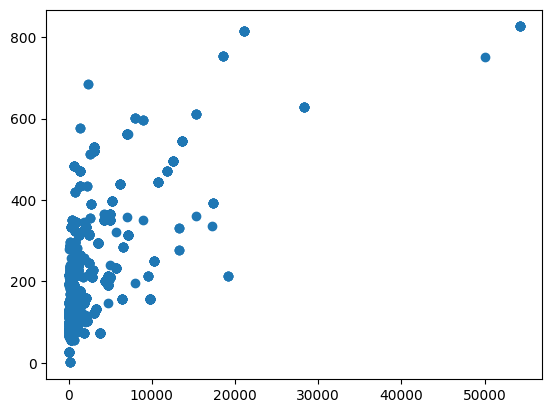

In [115]:
x = df_extr[['Transistors (million)']]
y = df_extr[['Die Size (mm^2)']]

plt.scatter(x, y)

In [112]:
df_extr.head()

,Product,Type,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,Rank
0,Sony Playstation 2 GPU 250nm,GPU,250.0,79.0,279.0,54.0,147.0,Sony,Other,F
1,ATI Radeon DDR,GPU,180.0,23.0,115.0,30.0,166.0,TSMC,ATI,F
2,ATI Radeon 7200 64 MB,GPU,180.0,23.0,111.0,30.0,166.0,TSMC,ATI,F
3,ATI Radeon 7200,GPU,180.0,23.0,111.0,30.0,166.0,TSMC,ATI,F
4,ATI Radeon 7200,GPU,180.0,23.0,111.0,30.0,143.0,TSMC,ATI,F


In [24]:
vendedor = df_exp.groupby("Vendor")["Type"].value_counts().rename("Total").to_frame().reset_index()
vendedor

,Vendor,Type,Total
0,AMD,CPU,918
1,AMD,GPU,698
2,ATI,GPU,525
3,Intel,CPU,1197
4,Intel,GPU,127
5,NVIDIA,GPU,1174
6,Other,GPU,58


In [25]:
fig = px.bar(data_frame= vendedor, x = "Vendor", y= "Total", color= "Type", barmode="group")
fig.show()

#### Análise de frquência

In [31]:
df_cpu = df_exp[df_exp["Type"] == "CPU"]
df_gpu = df_exp[df_exp["Type"] == "GPU"]

In [32]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Freq (MHz)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Freq (MHz)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Frequency (MHz) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Freq (MHz)</b>", secondary_y=False)

fig.show()

#### Analise Proccess Size

In [30]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Process Size (nm)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Process Size (nm)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Process Size (nm) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Process Size (nm)</b>", secondary_y=False)

fig.show()

#### Analise dos Transistors

In [33]:
df_transistors = df_exp.groupby([df_exp.index.year, "Type"])["Transistors (million)"].mean().rename("Mean").to_frame().reset_index()
df_transistors.head()

,Release Date,Type,Mean
0,2000.0,CPU,38.133333
1,2000.0,GPU,28.242578
2,2001.0,CPU,64.547945
3,2001.0,GPU,43.285205
4,2002.0,CPU,52.162162


In [34]:
fig = px.bar(data_frame=df_transistors, x= "Release Date", y = "Mean", color= "Type", barmode="group", title= "Mean number of Transistors (million) by year")
fig.show()

#### Frequencia x Processor Size x Release Year

In [35]:
fig = px.scatter(data_frame=df_cpu, x= "Freq (MHz)", y = "Process Size (nm)", color= df_cpu.index.year, title= "CPU Frequency (MHz) vs Processor Size (nm) vs Release year", labels={"color": "Years"},
                hover_name= "Product")
fig.show()

##### a) Amostragem estratificada em Conjunto de Treinamento e Conjunto de Teste

### Modelo

#### Divisão de conjuntos, treino e teste

In [80]:
def amostragem_estratificada(test_set):
    return (test_set['Rank'].value_counts() / len(test_set)) 

In [61]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df_extr, df_extr['Rank']):
  strat_train_set = df_extr.loc[train_index]
  strat_test_set = df_extr.loc[test_index]

In [81]:
amostragem_estratificada(strat_test_set)

F     0.252372
C     0.197343
B     0.185958
D     0.153700
E     0.125237
A     0.066414
S     0.015180
S+    0.003795
Name: Rank, dtype: float64

In [ ]:
strat_train_set.drop(columns=['Rank'], inplace=True)
strat_test_set.drop(columns=['Rank'], inplace=True)
cpu = strat_train_set.drop('Transistors (million)', axis=1)

##### Padronização dos dados

In [45]:
num_attribs = list(df.describe(include=np.number))

In [46]:
padronizacao_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

##### Atributos categóricos

In [47]:
cat_attribs = ['Vendor']

##### Full Pipeline

In [71]:
full_pipeline = ColumnTransformer([
        ('num_attr', padronizacao_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])

In [72]:
strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set)

In [73]:
strat_test_set_prepared = full_pipeline.fit_transform(strat_test_set)

##### Treinamento do modelo - Regressão Linear

In [ ]:
cpu_labels = strat_train_set['Transistors (million)'].copy()
x = df[['Transistors (million)']]
y = df[['Die Size (mm^2)']]

lin_reg = LinearRegression()
lin_reg.fit(x, y)

In [ ]:
plt.scatter(x, y)

In [116]:
c_angular = lin_reg.coef_
c_linear = lin_reg.intercept_

NameError: name 'lin_reg' is not defined

In [ ]:
plt.scatter(x, y)
plt.plot(x, c_linear + c_angular * x, color='red')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

cpu_predictions = lin_reg.predict(cpu_prepared)
lin_rmse = mean_squared_error(cpu_labels, cpu_predictions, squared=False)

In [ ]:
cpu_predictions

In [ ]:
round(lin_rmse, 2)

# 2.4 Requisitos da Construção dos Modelos e Aprendizado de Máquina 

### Seleção dos Modelos